# Project: AI-generated text detection 🤖
--------------------------------

**Dr. Dave Wanik - (OPIM 5512: Data Science Using Python) AND (OPIM 5509: Introduction to Deep Learning) - University of Connecticut**

Can you predict the 'ind' (0= human, 1 = AI) as a function of the 768 document embeddings, the word count and the punctuation? Be careful - there is imbalanced data which may require some advanced methods in order to get a reasonable model. Can you beat a naive (majority class) model or logistic regression? Now is your time to shine and apply everything you learned.

This project is being given to both classes simultaneously - however, you should only use the methods taught in each class. DS students must use only `sklearn` models, DL students must use `keras` models taught in class. DS students may use `XGBoost()` if they want, but this is at their own risk. `autoML` and `autokeras` may be used to fit models, but students still must be rigorous in their evaluation of the models.

Come to office hours EARLY with any questions that might pop up. See end of notebook for rubric.


*   Team Member Names: Geethasree Madiraju Nagaraju, Hunjoo Lee, Pradeepti Dokka
*   Group Number: 7
* My best F1 score on the test data was:
  * (this must match the output in your script or you are in last place! - use `f1_score(y_test, test_preds)` to check your F1 score)



In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix


from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
#
import xgboost as xgb


In [ ]:
# !gdown 1v4ih6bo-cHpWl9JB1iiMwJk_4gc_GKas

In [ ]:
import pandas as pd
#This is the right dataset for our project -- Geetha
# https://drive.google.com/file/d/1v4ih6bo-cHpWl9JB1iiMwJk_4gc_GKas/view?usp=sharing
!gdown 1v4ih6bo-cHpWl9JB1iiMwJk_4gc_GKas

Downloading...
From: https://drive.google.com/uc?id=1v4ih6bo-cHpWl9JB1iiMwJk_4gc_GKas
To: /content/ai-text-competition-data.zip
100% 50.8M/50.8M [00:00<00:00, 91.4MB/s]


In [ ]:
# unzip it
!unzip ai-text-competition-data.zip

# read it
df = pd.read_csv('/content/ai-text-competition/training_set.csv')

Archive:  ai-text-competition-data.zip
   creating: ai-text-competition/
  inflating: ai-text-competition/solution_format.csv  
  inflating: ai-text-competition/test_set.csv  
  inflating: ai-text-competition/training_set.csv  


Ideas for Data Visualization
1. Word Count comparison for ai vs human text
2. Punctuation comparison for AI vs human
3. Scatter plot between Word Count and Punct count
4. Histogram of 20 embedding features - normal distribution
5. Convert 768D to 2D using PCA and visualize on 2D - AI vs Human - how clustered are they based on two most important Principal Components
6. plot highest variance to least variance embedding features

Ideas for Feature Engineering

Questions:
Should the visualizations be only on raw data?

# 1.EDA

In [ ]:
df.shape

(11144, 772)

In [ ]:
df.head(5)

,ID,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,word_count,punc_num,ind
0,1,0.231980,-0.190620,-0.985933,-0.233773,-0.355879,-0.488884,0.254773,-0.121213,-0.820528,...,0.101373,0.575414,-0.567646,-0.051293,0.455840,0.065538,0.020671,25,14,0
1,2,0.168223,-1.204551,-0.596952,-0.722583,0.284799,-0.238639,-0.410948,-0.090654,1.220703,...,0.407270,0.769329,0.555820,0.252843,0.603888,1.240028,-0.076253,23,4,0
2,3,0.522005,-0.759933,-1.209413,0.301834,0.361126,0.158161,-0.117013,0.313158,1.102455,...,0.143658,0.874958,0.679421,0.393198,0.439103,0.742181,-0.430493,29,8,0
3,4,0.038746,-1.408335,-0.580810,0.353450,1.142353,-0.418879,-0.134133,-0.199796,1.071100,...,0.728436,0.540930,1.968447,0.185315,0.630167,0.577032,0.117681,14,3,0
4,5,-0.307572,0.103575,-0.368605,-0.378654,-0.285990,-0.508058,-0.254869,-0.108291,-0.095139,...,-0.146845,0.497731,-0.299924,-0.020024,0.975511,-0.342360,-0.428779,35,9,0


In [ ]:
# descriptive statistics of all the columns
df.describe()

,ID,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,word_count,punc_num,ind
count,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,...,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000
mean,5572.500000,0.146012,-0.273505,-0.666907,-0.415562,-0.230934,-0.270790,-0.039869,-0.037003,0.101543,...,0.274985,0.687529,0.269849,0.199639,0.443093,0.078578,-0.062243,29.978643,7.347003,0.098708
std,3217.140034,0.389374,0.382566,0.432605,0.745149,0.583487,0.388663,0.292493,0.246509,0.503054,...,0.406760,0.431843,0.545066,0.304694,0.365657,0.551214,0.300848,10.271548,4.041350,0.298283
min,1.000000,-1.633110,-1.971542,-2.505377,-4.280401,-2.413613,-1.514833,-1.427118,-1.036038,-1.779871,...,-1.765492,-1.723701,-1.506003,-1.272904,-1.467510,-1.605773,-1.085949,5.000000,0.000000,0.000000
25%,2786.750000,-0.111816,-0.517288,-0.954874,-0.891329,-0.633606,-0.536751,-0.229016,-0.197038,-0.236033,...,-0.000389,0.392865,-0.125641,0.000539,0.208861,-0.303969,-0.273816,22.000000,4.000000,0.000000
50%,5572.500000,0.161513,-0.261028,-0.673000,-0.415641,-0.244129,-0.281473,-0.036129,-0.038384,0.068244,...,0.256874,0.683075,0.213906,0.205270,0.461389,0.021472,-0.074150,30.000000,7.000000,0.000000
75%,8358.250000,0.418461,-0.016541,-0.381686,0.078408,0.168207,-0.018891,0.157572,0.117311,0.399803,...,0.535327,0.981356,0.634109,0.400167,0.692926,0.405299,0.129446,38.000000,10.000000,0.000000
max,11144.000000,1.378549,1.376324,1.392311,2.184251,1.659698,1.667419,1.070739,1.320982,2.456948,...,1.987709,1.965830,2.582598,1.375909,1.879438,2.579186,1.674109,57.000000,27.000000,1.000000


In [ ]:
#check if there are any null values in any of the columns
df.isna().sum().sum()

0

In [ ]:
# target class distribution
df['ind'].value_counts()

0    10044
1     1100
Name: ind, dtype: int64

### Histograms of 20 word embeddings features

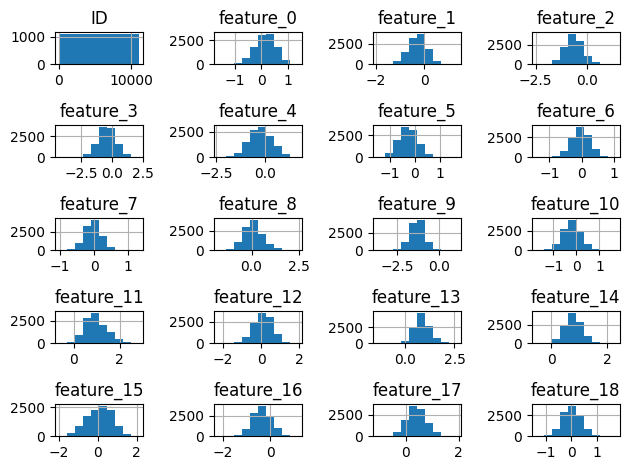

In [ ]:
# histograms
df.iloc[:,:20].hist()
plt.rcParams["figure.figsize"] = (50,50)
plt.tight_layout()
plt.show()

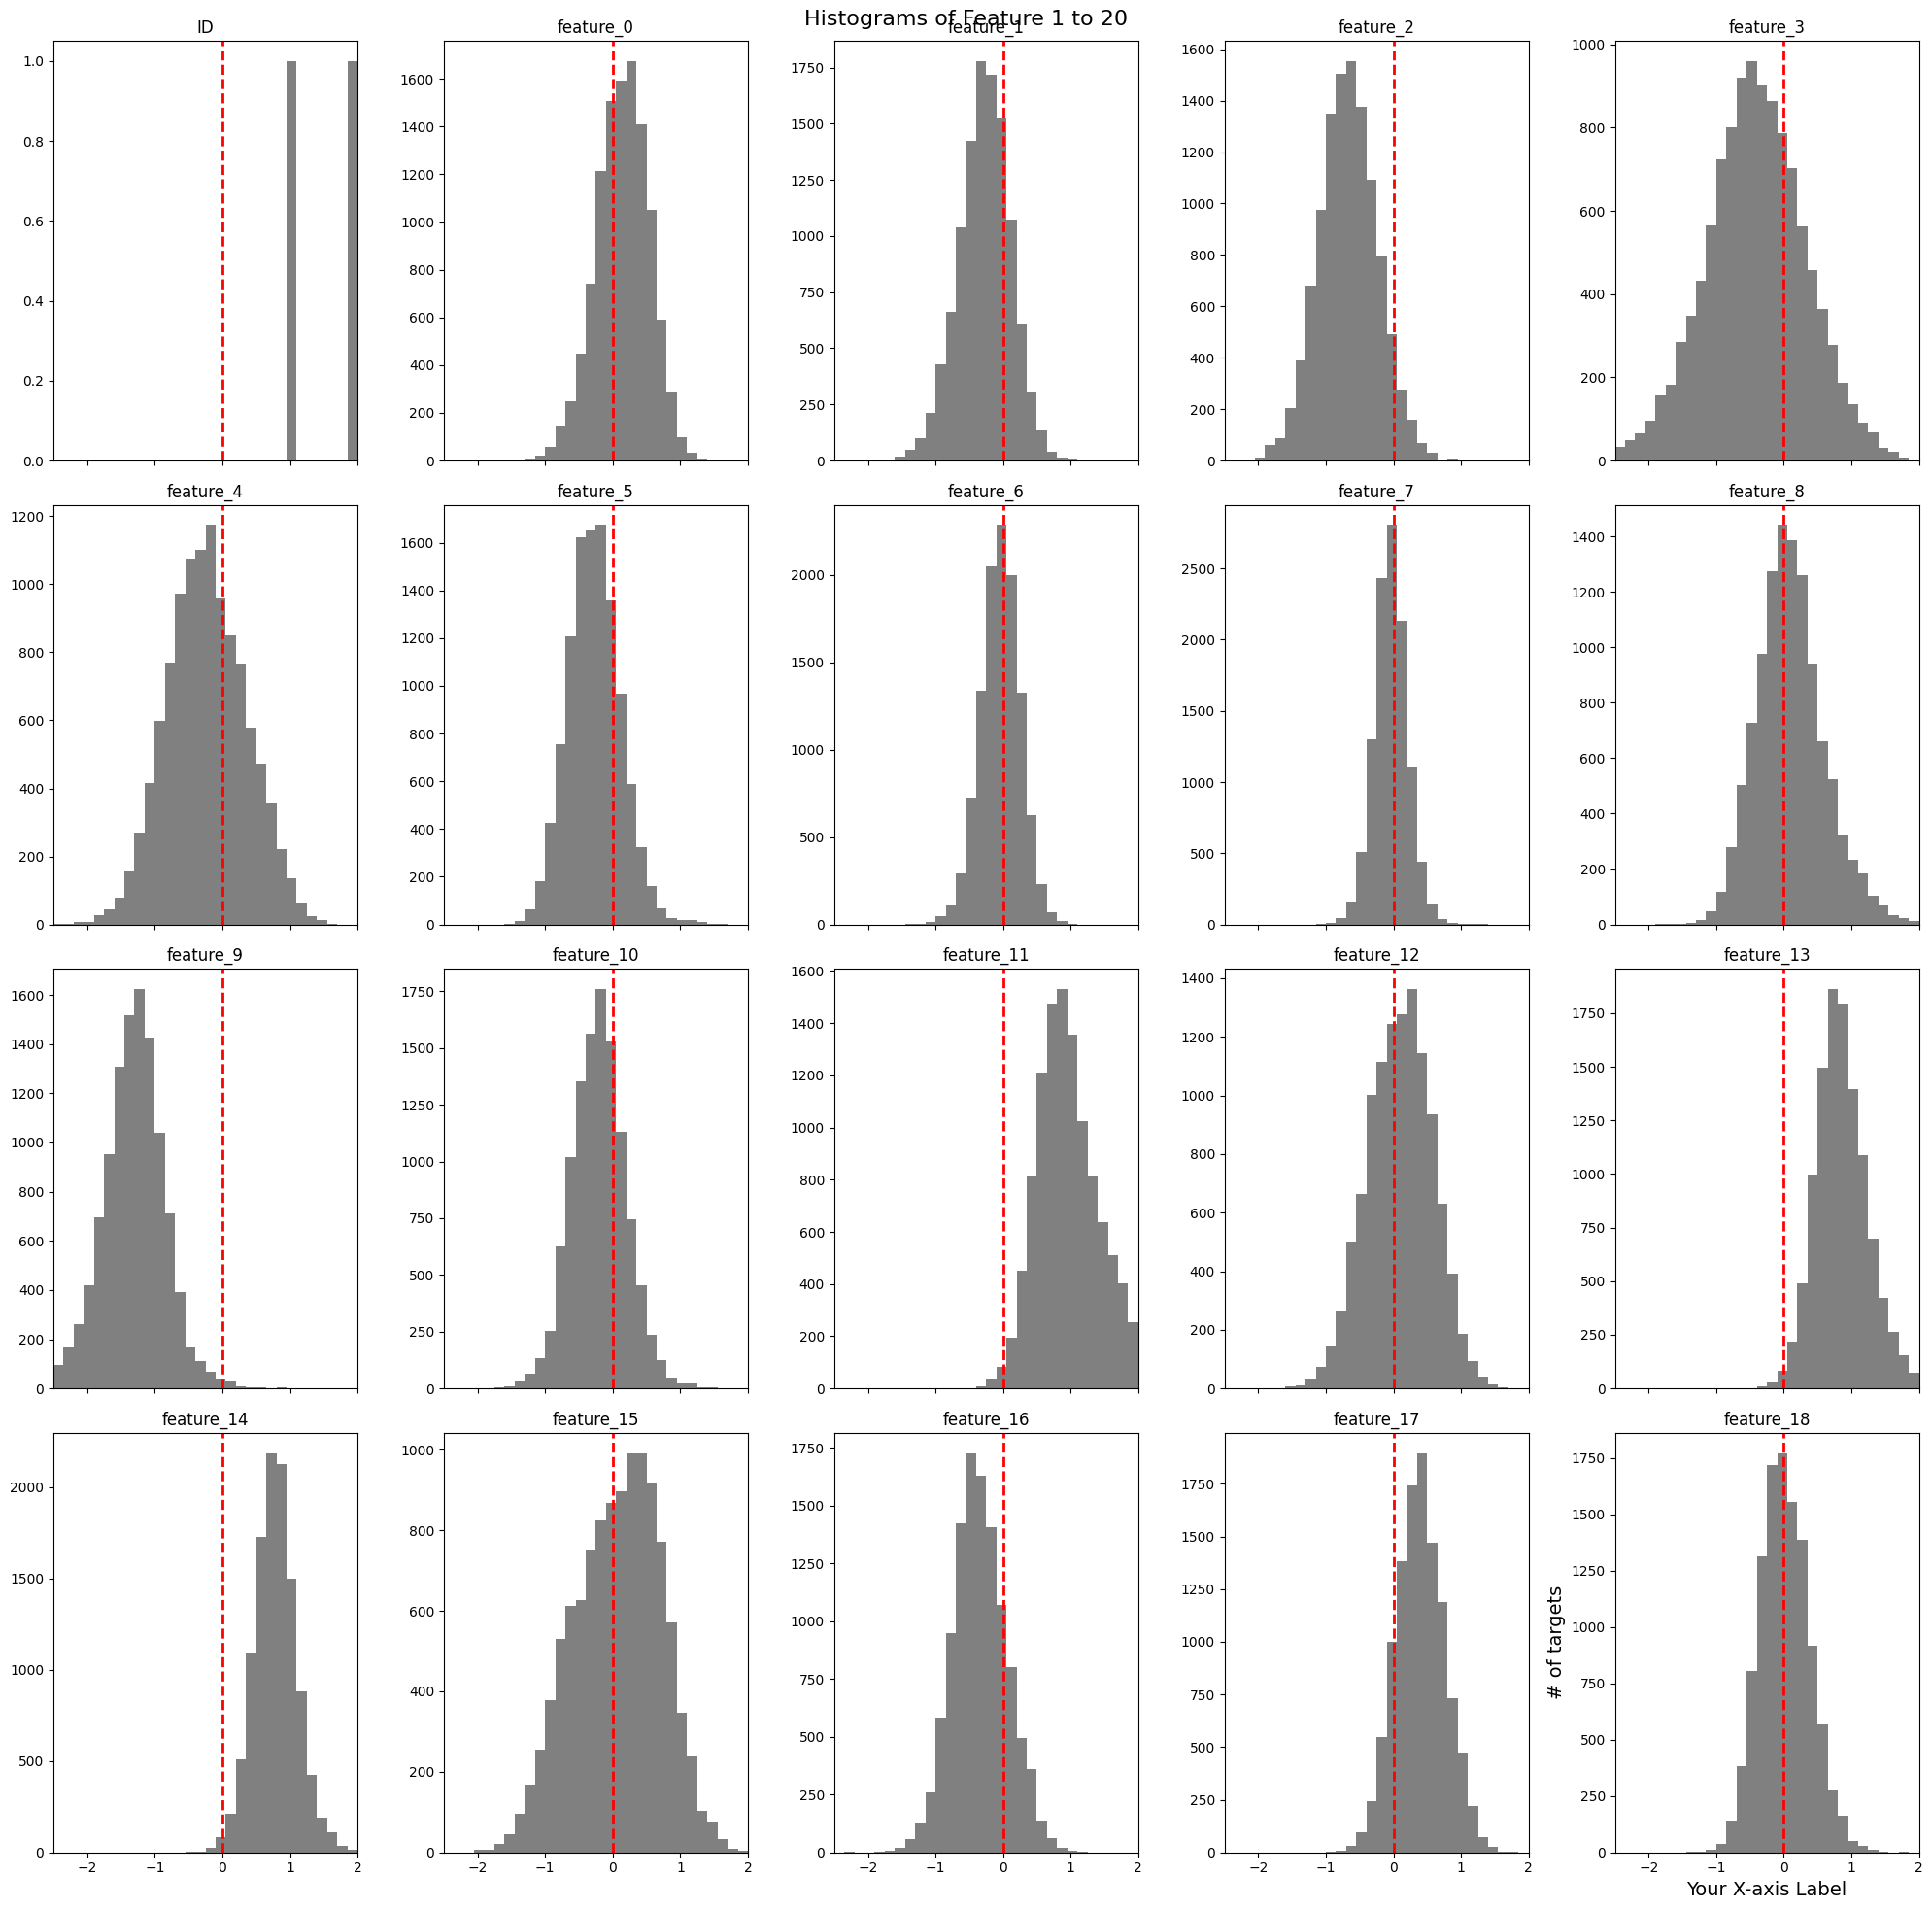

In [ ]:
# Get the number of columns you want to plot
num_cols = 20

# Set the common x-axis range
x_axis_range = (-2.5, 2.0)

# Calculate the number of rows and columns for the subplot grid
num_rows = num_cols // 5 + (num_cols % 5 > 0)  # Ceiling division

# Create subplots with a shared x-axis
fig, axes = plt.subplots(nrows=num_rows, ncols=5, sharex=True, figsize=(20, 20))

# Plot histograms for each column
for i in range(num_cols):
    row, col = divmod(i, 5)
    axes[row, col].hist(df.iloc[:, i], bins=30, facecolor='gray', align='mid', range=x_axis_range)
    axes[row, col].set_title(f'{df.columns[i]}')
    axes[row, col].set_xlim(x_axis_range)  # Set the x-axis range for each subplot
    axes[row, col].axvline(x=0, color='red', linestyle='dashed', linewidth=2)  # Add a vertical line at x=0

# Add labels and title
plt.xlabel('Your X-axis Label', fontsize=14)
plt.ylabel('# of targets', fontsize=14)
plt.suptitle('Histograms of Feature 1 to 20', fontsize=16)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

~~Embedding Features seem to be mostly normally distributed around a mean of 0~~

The embedding features appear to be mostly normally distributed, but it was also observed that not all features are distributed around a mean of 0.

### Word Count of Human vs AI generated Text

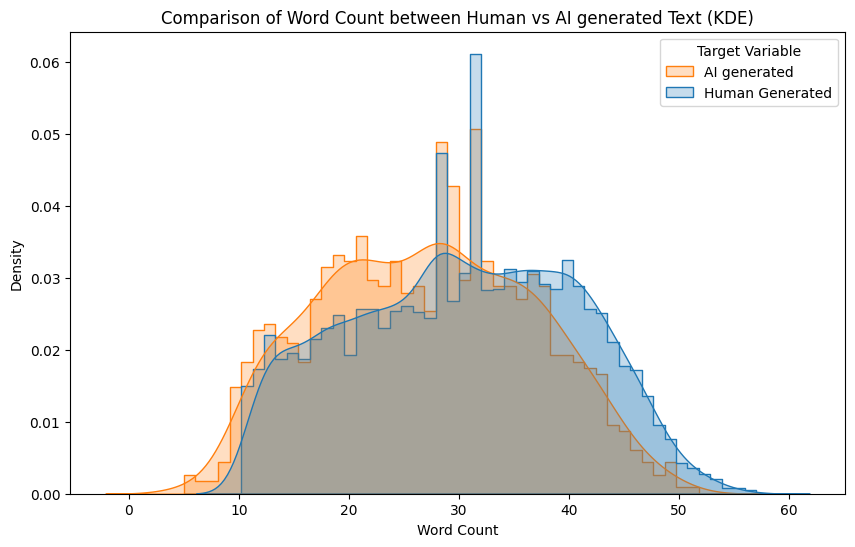

In [ ]:
# KDE plot to compare word count between target variables
plt.figure(figsize=(10, 6))
# sns.kdeplot(data=df, x='word_count', hue='ind', fill=True, common_norm=False)
# sns.histplot(data=df, x='word_count', hue='ind', element="step", common_norm=False, stat="density", kde=True, bins=50)
sns.histplot(data=df, x='word_count', hue='ind', element="step", common_norm=False, stat="density", bins=50)
sns.kdeplot(data=df, x='word_count', hue='ind', fill=True, common_norm=False)
plt.title('Comparison of Word Count between Human vs AI generated Text (KDE)')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.legend(title='Target Variable', labels=['AI generated', 'Human Generated'])
plt.show()

It can be observed that Human generated text has slightly higher number of words than AI generated text. However, there is a huge overlap between word counts of Text generated by Humans and AI.

### Punctuation Count of Human Vs AI Generated Text

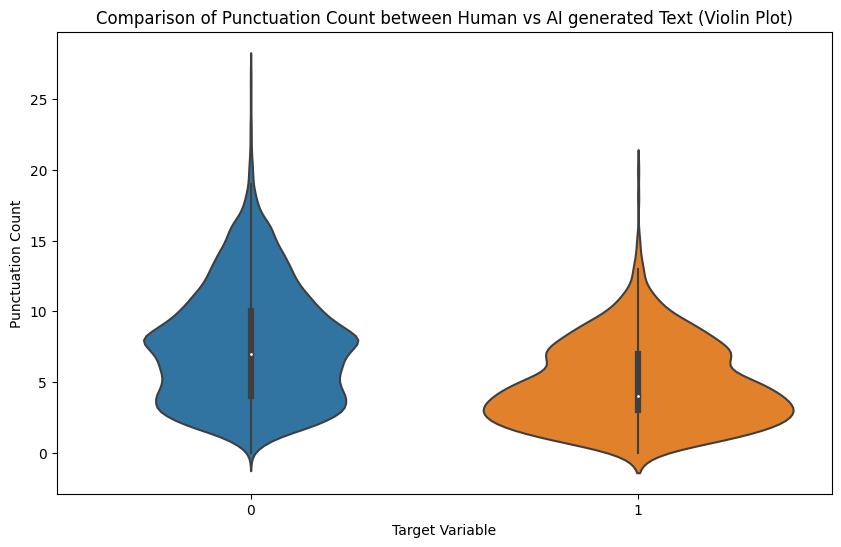

In [ ]:
# Violin plot to compare punctuation count between target variables
plt.figure(figsize=(10, 6))
sns.violinplot(x='ind', y='punc_num', data=df)
plt.title('Comparison of Punctuation Count between Human vs AI generated Text (Violin Plot)')
plt.xlabel('Target Variable')
plt.ylabel('Punctuation Count')
plt.show()

From the violin plot, it can be observed that AI generated text typically has lower punctuation count than that of Human generated text.

### Relationship between Word Count and Punctuation number

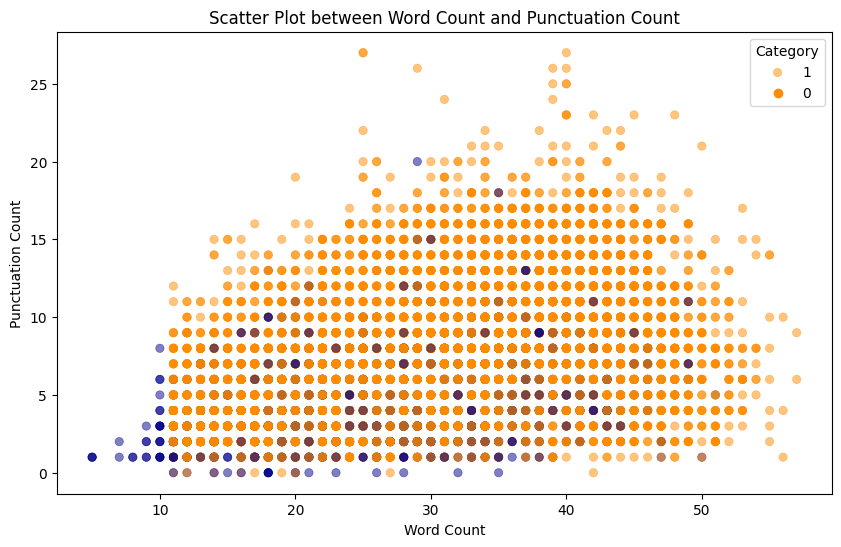

In [ ]:
# Scatter plot with different colors and light fill
plt.figure(figsize=(10, 6))
sns.scatterplot(x='word_count', y='punc_num', hue='ind', data=df, palette={1: 'darkblue', 0: 'darkorange'}, alpha=0.5, edgecolor=None)
plt.title('Scatter Plot between Word Count and Punctuation Count')
plt.xlabel('Word Count')
plt.ylabel('Punctuation Count')
plt.legend(title='Category', labels=['1', '0'])
plt.show()

There does not seem to be any increasing relationship between word count and punctuation number. Even at higher word counts like around 40-50, punctuation number ranges from as low as 0 through as high as 25.

### Variances in Embedding Features

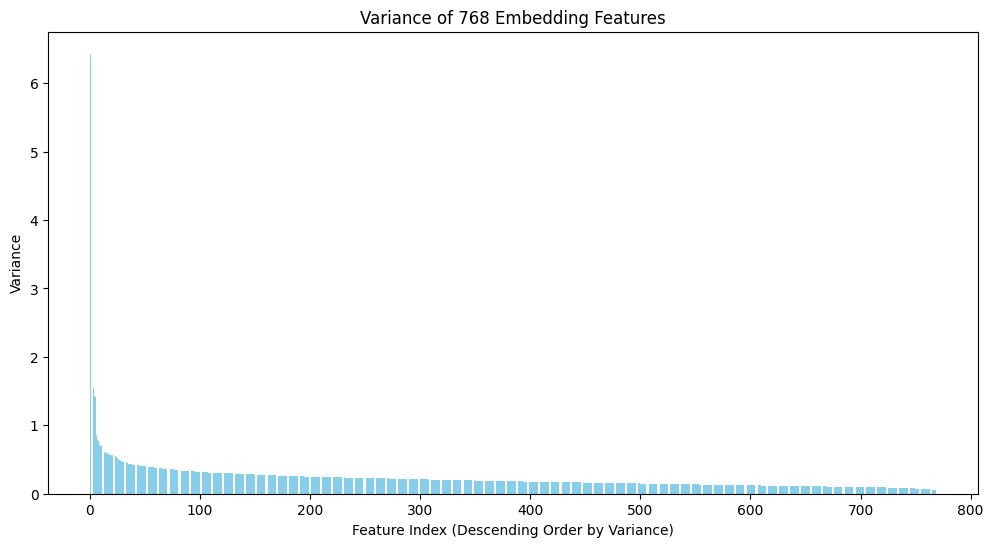

In [ ]:
embedding_feature_cols = [col for col in df.columns if 'feature' in col]
embeddings = df[embedding_feature_cols]

# Calculate variance for each feature
variances = np.var(embeddings, axis=0)

# Get the indices to sort features by variance in descending order
sorted_indices = np.argsort(variances)[::-1]

# Sort variances and feature indices accordingly
sorted_variances = variances[sorted_indices]

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(variances) + 1), sorted_variances, color='skyblue')
plt.title('Variance of 768 Embedding Features')
plt.xlabel('Feature Index (Descending Order by Variance)')
plt.ylabel('Variance')
plt.show()

Most of the embedding features seem to have low variances. There are also few embedding features that have highest variance.

### Use PCA to convert 768D to 2D for visualization

Explained Variance Ratio by top two princial Components:  [0.18221394 0.07443062]


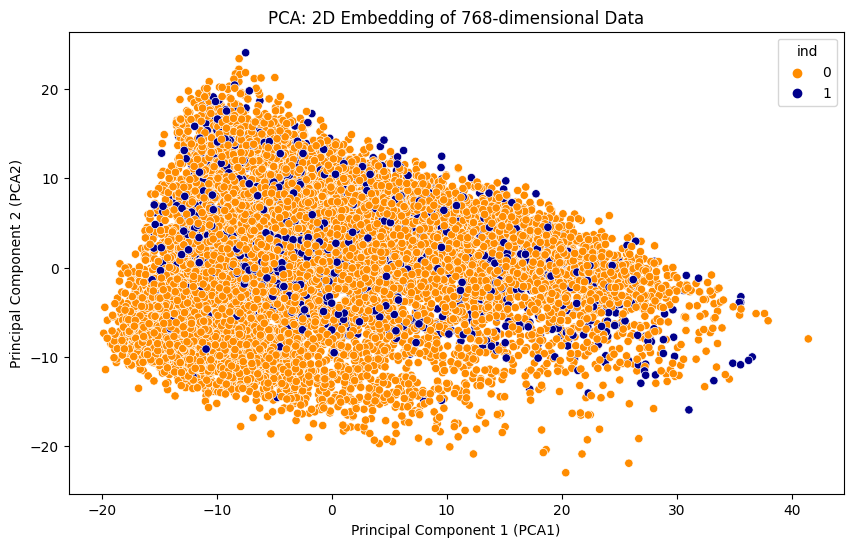

In [ ]:
embedding_feature_cols = [col for col in df.columns if 'feature' in col]
embeddings = df[embedding_feature_cols]
y_ind = df['ind']
# Standardize the features
embeddings = StandardScaler().fit_transform(embeddings)

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
embeddings = pca.fit_transform(embeddings)
print("Explained Variance Ratio by top two princial Components: ", pca.explained_variance_ratio_)
# Create a DataFrame for the reduced data
df_pca = pd.DataFrame(data={'PCA1': embeddings[:, 0], 'PCA2': embeddings[:, 1], 'ind': y_ind})

# Plot the reduced data
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='ind', data=df_pca, palette={0: 'darkorange', 1: 'darkblue'})
plt.title('PCA: 2D Embedding of 768-dimensional Data')
plt.xlabel('Principal Component 1 (PCA1)')
plt.ylabel('Principal Component 2 (PCA2)')
# plt.legend(title='Category', labels=['ind=0', 'ind=1'])
plt.show()

Visualizing top two principal components that explain 25% of the variance (combined) in all the embeddings for AI vs Human generated text, we can observe that the data points are mostly overlapping and there is no clear seperation between the two clusters and model might struggle to classify just based on these two Principal Components alone. However, since this was solely for visualization purpose and including additional principal components could help in model classifying the data points better.

---



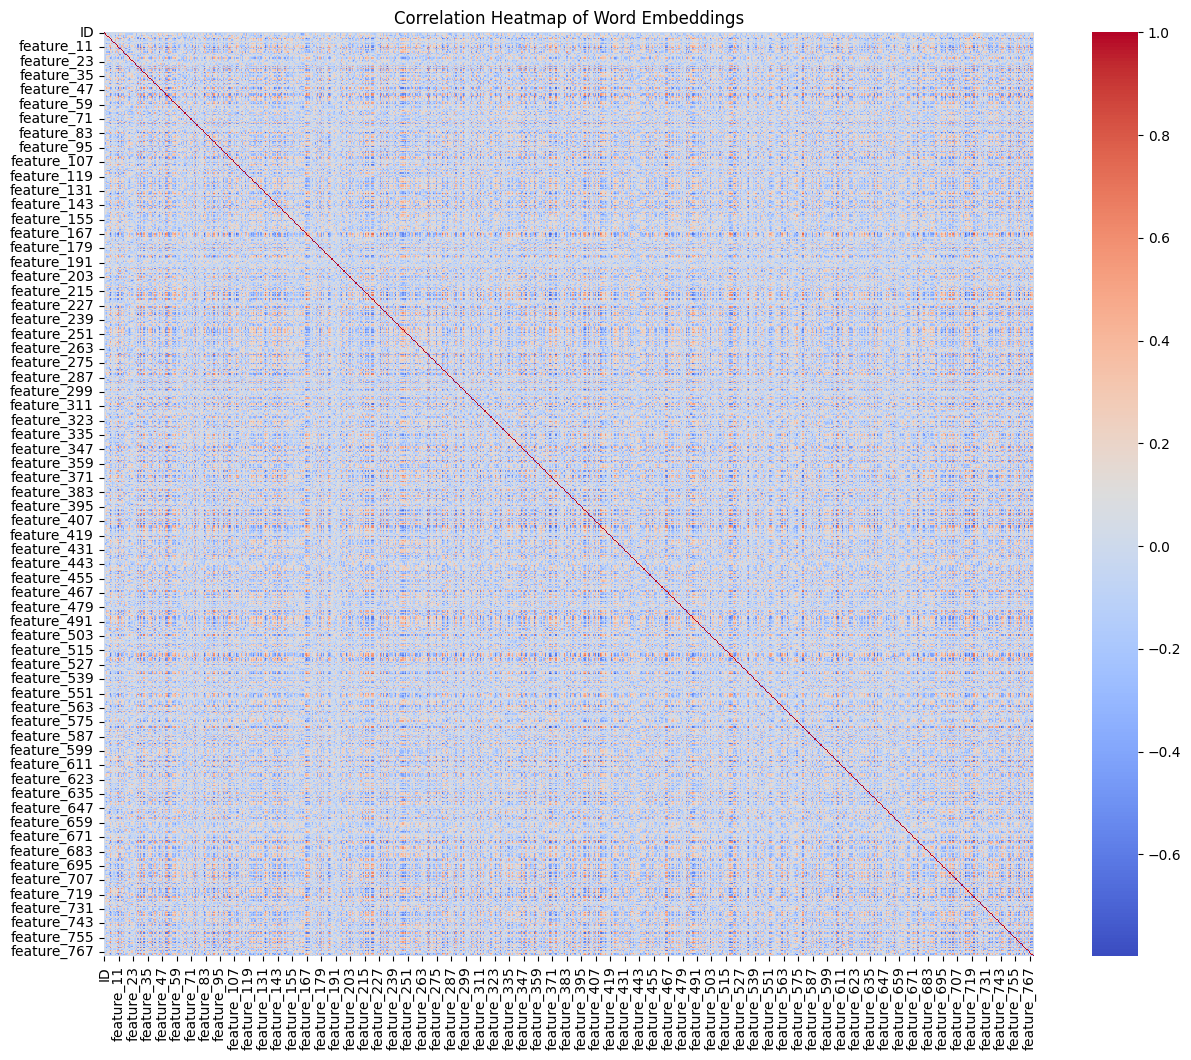

In [ ]:
plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap of Word Embeddings')
plt.show()

# 2.Prepare Data for Modeling

## Feature Engineering

## Train Test Split

In [ ]:
# Split data into X and y
X = df.drop(['ID','ind'],axis=1)
y = df['ind']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)

(11144, 770) (10029, 770) (1115, 770)
(11144,) (10029,) (1115,)


## Standard Scaler

In [ ]:
# Initialize the Standard Scaler
scaler = StandardScaler()

# Initialize the MinMaxScaler
# scaler = MinMaxScaler()

# Fit the scaler to the data and transform the data
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

## PCA for dimensionality reduction

In [ ]:
# apply PCA on text embeddings to reduce dimensionality
pca = PCA(n_components = 0.95) #, svd_solver = 'full'
feature_cols=[col for col in X_train.columns if "feature" in col]
other_cols = [col for col in X_train.columns if "feature" not in col]
print(len(feature_cols))
X_train_pca = pca.fit_transform(X_train[feature_cols])
X_test_pca = pca.transform(X_test[feature_cols])
print(pca.n_components_)
X_train_pca = pd.DataFrame(X_train_pca, columns=[f'PCA_{i}' for i in range(pca.n_components_)])
X_test_pca = pd.DataFrame(X_test_pca, columns=[f'PCA_{i}' for i in range(pca.n_components_)])
X_train = pd.concat([X_train_pca, X_train[other_cols]], axis=1)
X_test = pd.concat([X_test_pca, X_test[other_cols]], axis=1)
print(X_train.shape)
print(X_test.shape)

768
248
(10029, 250)
(1115, 250)


## Data Balancing

In [ ]:
# Highly imbalanced dataset - Need to balance both classes before modelling
# Create a SMOTETomek instance
smote_tomek = SMOTETomek(sampling_strategy='auto')
# Fit and transform the data
X_train, y_train = smote_tomek.fit_resample(X_train, y_train)
#After resampling, check the shape of the data
print(X_train.shape)
print(y_train.shape)
print(y_train.value_counts())

(18078, 250)
(18078,)
0    9039
1    9039
Name: ind, dtype: int64


# 3.Models/Evaluation

### Spot Checking

This code conducts a spot check of various classification algorithms, including Logistic Regression, K-Nearest Neighbors, Gaussian Naive Bayes, Support Vector Classifier, Decision Tree Classifier, Random Forest Classifier, and Gradient Boosting Classifier. Using 10-fold cross-validation with a random seed of 42, the code here evaluates each model on the training data, calculating the F1 score for each fold. The mean and standard deviation of these F1 scores are printed for each algorithm, providing insights into their performance on the given dataset. We aim for a comparative analysis of different classifiers to inform model selection based on cross-validated F1 scores.

In [ ]:
# Spot Check Algorithms
models = []
models.append(('LogR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('SVC', SVC()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('GBoost', GradientBoostingClassifier()))
models

# 5-fold CV
num_folds = 10
seed = 42
scoring = 'f1'

# evaluate each model in turn
results = []
names = []
for name, model in models:
  # this makes an INDEX (between 1 and 10)
	kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

  # save the val results from X train
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogR: 0.869957 (0.005857)
KNN: 0.876796 (0.007020)
GNB: 0.749237 (0.008742)
SVC: 0.979443 (0.003157)
DTC: 0.881451 (0.006126)
RF: 0.987051 (0.002423)
GBoost: 0.898324 (0.004879)


[array([0.87314662, 0.86314594, 0.86993603, 0.86341725, 0.87923251,
       0.87029759, 0.86912752, 0.86022666, 0.87513455, 0.87590428]), array([0.88330871, 0.8685259 , 0.8838312 , 0.87885986, 0.86470588,
       0.87407407, 0.86842105, 0.8847619 , 0.8829686 , 0.87850467]), array([0.7486688 , 0.73500545, 0.75232198, 0.7517278 , 0.77057221,
       0.74008811, 0.74824798, 0.74805195, 0.75025694, 0.74743104]), array([0.98292011, 0.9741573 , 0.97939778, 0.97879109, 0.97601785,
       0.98269123, 0.9827682 , 0.98085106, 0.97511911, 0.98171745]), array([0.88463641, 0.87367835, 0.89110994, 0.88771745, 0.88503254,
       0.8870614 , 0.87804878, 0.87827912, 0.87656904, 0.8723748 ]), array([0.98596294, 0.9902467 , 0.98489752, 0.98478261, 0.98465037,
       0.99092971, 0.9846852 , 0.99029126, 0.98646454, 0.98759865]), array([0.89160645, 0.89871293, 0.89283847, 0.89936441, 0.89988751,
       0.90623245, 0.89252591, 0.90073918, 0.89585547, 0.90547264])]


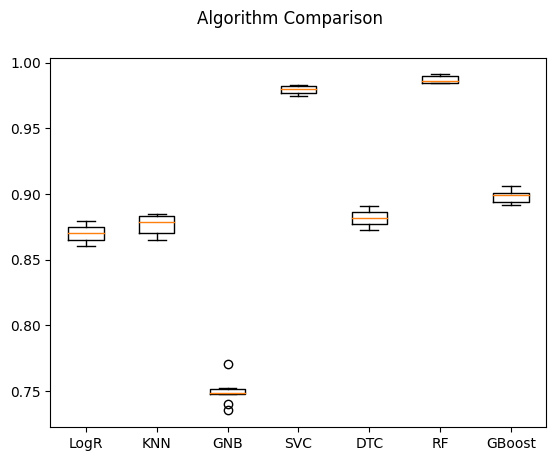

In [ ]:
print(results)
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.suptitle('Algorithm Comparison')
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

~~Based on the results of spot checking, with the default parameters, SVC and Gradient Boosting Classifier resulted in highest scores. Hence performing Hyperparameter tuning for these models using GridSearchCV can help improve their performance~~

Based on the spot-checking results using default parameters, both the Support Vector Classifier (SVC) and Random Forest Classifier stand out with exceptionally high mean F1 scores and low standard deviations, suggesting strong and consistent performance. Hence, we have concluded that conducting hyperparameter tuning for these models through GridSearchCV has the potential to enhance their performance further.

### Hyperparameter Tuning on the best models

In [ ]:
# Set grid search params
grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
                  'clf__C': [1, 10],
                  'clf__solver': ['liblinear'],
                   'clf__max_iter': [1000000]}]

grid_params_knn = [{'clf__n_neighbors': [1, 3, 5, 10, 50]}]

grid_params_dt = [{'clf__criterion': ['gini', 'entropy'],
                  'clf__min_samples_leaf': [5, 10, 20, 25],
                  'clf__max_depth': [3, 5, 10, 15, 20],
                  'clf__min_samples_split': [5, 10, 20, 25]}]

grid_params_svc = [{'clf__C': [0.1, 1, 10],
		                'clf__kernel': ['linear', 'rbf', 'poly'],
                    'clf__degree' : [2, 3, 4],
                    'clf__gamma' : ['scale', 'auto', 0.1, 1]}]

grid_params_gb = [{'clf__n_estimators': [3, 5, 10, 15, 20],
                'clf__learning_rate': [0.001, 0.01],
                'clf__loss': ['deviance', 'exponential']}]

grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
                  'clf__min_samples_leaf': [5, 10, 20, 25],
                  'clf__max_depth': [3, 5, 10, 15, 20],
                  'clf__min_samples_split': [5, 10, 20, 25],
                  'clf__n_estimators': [30, 50, 100, 200, 500]}]

In [ ]:
# Construct some pipelines

pipe_lr = Pipeline([
      # ('smotetmk', SMOTETomek(random_state=42)),
			('clf', LogisticRegression(random_state=42))
   ])

pipe_knn = Pipeline([
      # ('smotetmk', SMOTETomek(random_state=42)),
			('clf', KNeighborsClassifier())
   ])

pipe_dt = Pipeline([
      # ('smotetmk', SMOTETomek(random_state=42)),
			('clf', DecisionTreeClassifier(random_state=42))
   ])

pipe_svc = Pipeline([
      # ('smotetmk', SMOTETomek(random_state=42)),
			('clf', SVC(random_state=42))
   ])

pipe_rf = Pipeline([
      # ('smotetmk', SMOTETomek(random_state=42)),
			('clf', RandomForestClassifier(random_state=42))
   ])

pipe_gb = Pipeline([
      # ('smotetmk', SMOTETomek(random_state=42)),
			('clf', GradientBoostingClassifier(random_state=42))
   ])


In [ ]:
# Define Grid Search

gs_lr = GridSearchCV(estimator=pipe_lr,
    param_grid=grid_params_lr,
    scoring='f1',
    cv=10)

gs_knn = GridSearchCV(estimator=pipe_knn,
    param_grid=grid_params_knn,
    scoring='f1',
    cv=10)

gs_dt = GridSearchCV(estimator=pipe_dt,
    param_grid=grid_params_dt,
    scoring='f1',
    cv=10)

gs_svc = GridSearchCV(estimator=pipe_svc,
    param_grid=grid_params_svc,
    scoring='f1',
    cv=10)

gs_gb = GridSearchCV(estimator=pipe_gb,
    param_grid=grid_params_gb,
    scoring='f1',
    cv=10)

gs_rf = GridSearchCV(estimator=pipe_rf,
    param_grid=grid_params_rf,
    scoring='f1',
    cv=10)


# List of pipelines for ease of iteration
grids = [gs_lr, gs_knn, gs_dt, gs_svc, gs_gb, gs_rf]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Logistic Regression',
             1: 'KNN',
             2: 'DTC',
             3: 'SVC',
             4: 'GBC',
             5: 'RFC'}


In [ ]:
# Fit the grid search objects
print('Performing model optimizations...')
best_f1 = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
	print('\nEstimator: %s' % grid_dict[idx])
	# Fit grid search
	gs.fit(X_train, y_train)
	# Best params
	print('Best params: %s' % gs.best_params_)
	# Best training f1 score
	print('Best training f1 score: %.3f' % gs.best_score_)
	# Predict on test data with best params
	y_pred = gs.predict(X_test)
	# Test data f1 score of model with best params
	print('Test set f1 score for best params: %.3f ' % f1_score(y_test, y_pred))
	# Store Highest f1 score model and its parameters
	if f1_score(y_test, y_pred) > best_f1:
		best_f1 = f1_score(y_test, y_pred)
		best_gs = gs
		best_clf = idx
print('\nClassifier with best test set f1 score: %s' % grid_dict[best_clf])

Performing model optimizations...

Estimator: Logistic Regression
Best params: {'clf__C': 10, 'clf__max_iter': 1000000, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best training f1 score: 0.870
Test set f1 score for best params: 0.514 

Estimator: KNN
Best params: {'clf__n_neighbors': 1}
Best training f1 score: 0.923
Test set f1 score for best params: 0.393 

Estimator: DTC
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 20, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5}
Best training f1 score: 0.873
Test set f1 score for best params: 0.339 

Estimator: SVC


### Random Forest

In [ ]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the train and test set
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

# Evaluate the model
classification_report_train = classification_report(y_train, y_train_pred)
classification_report_test = classification_report(y_test, y_test_pred)

# Print the results
print("Classification Report Train:\n", classification_report_train)
print("Classification Report Test:\n", classification_report_test)

Classification Report Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9037
           1       1.00      1.00      1.00      9037

    accuracy                           1.00     18074
   macro avg       1.00      1.00      1.00     18074
weighted avg       1.00      1.00      1.00     18074

Classification Report Test:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      1005
           1       0.83      0.27      0.41       110

    accuracy                           0.92      1115
   macro avg       0.88      0.63      0.68      1115
weighted avg       0.92      0.92      0.90      1115



### XGBoost

In [ ]:
# Create a Random Forest classifier
xgb_classifier = xgb.XGBClassifier( random_state=42) #objective="binary:logistic",

# Train the classifier on the training data
xgb_classifier.fit(X_train, y_train)

# Make predictions on the train and test set
y_train_pred = xgb_classifier.predict(X_train)
y_test_pred = xgb_classifier.predict(X_test)

# Evaluate the model
classification_report_train = classification_report(y_train, y_train_pred)
classification_report_test = classification_report(y_test, y_test_pred)

# Print the results
print("Classification Report Train:\n", classification_report_train)
print("Classification Report Test:\n", classification_report_test)

Classification Report Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9037
           1       1.00      1.00      1.00      9037

    accuracy                           1.00     18074
   macro avg       1.00      1.00      1.00     18074
weighted avg       1.00      1.00      1.00     18074

Classification Report Test:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      1005
           1       0.71      0.44      0.54       110

    accuracy                           0.93      1115
   macro avg       0.82      0.71      0.75      1115
weighted avg       0.92      0.93      0.92      1115



### Naive Bayes

In [ ]:
# nb_classifier = MultinomialNB()
# # nb_classifier = GaussianNB()

# # Train the classifier on the training data
# nb_classifier.fit(X_train, y_train)

# # Make predictions on the train and test set
# y_train_pred = nb_classifier.predict(X_train)
# y_test_pred = nb_classifier.predict(X_test)

# # Evaluate the model
# classification_report_train = classification_report(y_train, y_train_pred)
# classification_report_test = classification_report(y_test, y_test_pred)

# # Print the results
# print("Classification Report Train:\n", classification_report_train)
# print("Classification Report Test:\n", classification_report_test)

### SVM

In [ ]:
svm_classifier = SVC(random_state=42)

# Train the classifier on the training data
svm_classifier.fit(X_train, y_train)

# Make predictions on the train and test set
y_train_pred = svm_classifier.predict(X_train)
y_test_pred = svm_classifier.predict(X_test)

# Evaluate the model
classification_report_train = classification_report(y_train, y_train_pred)
classification_report_test = classification_report(y_test, y_test_pred)

# Print the results
print("Classification Report Train:\n", classification_report_train)
print("Classification Report Test:\n", classification_report_test)

Classification Report Train:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      9037
           1       0.99      1.00      0.99      9037

    accuracy                           0.99     18074
   macro avg       0.99      0.99      0.99     18074
weighted avg       0.99      0.99      0.99     18074

Classification Report Test:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      1005
           1       0.68      0.57      0.62       110

    accuracy                           0.93      1115
   macro avg       0.82      0.77      0.79      1115
weighted avg       0.93      0.93      0.93      1115



### Permutation Importance

In [ ]:
from sklearn.inspection import permutation_importance

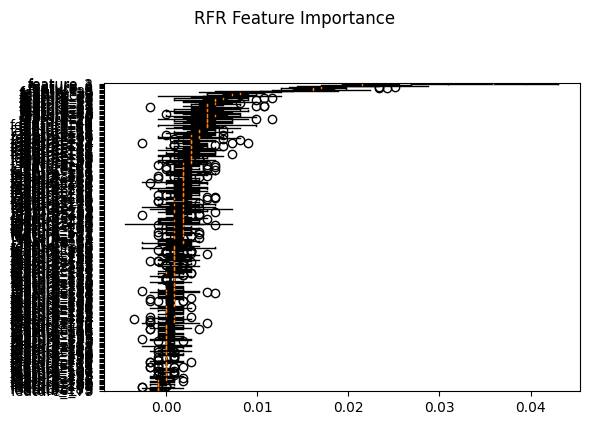

In [ ]:
# let's make this repeatable! all you need to do is assign
# a model object to clf!

# RFC
clf = svm_classifier
result = permutation_importance(clf, X_test, y_test, n_repeats=15, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=X.columns[perm_sorted_idx])
fig.suptitle('RFR Feature Importance', y=1.05)
fig.tight_layout()
plt.show()


# clf = rf_classifier # just update the title!

# result = permutation_importance(clf, X_test, y_test, n_repeats=15,
#                                 random_state=42)
# perm_sorted_idx = result.importances_mean.argsort()

# tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
# tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

# fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
# ax1.boxplot(result.importances[perm_sorted_idx[-3:]].T, vert=False,
#             labels=X.columns[perm_sorted_idx][-3:]) # only to print top 3 variables
# fig.suptitle('RFR Feature Importance', y=1.05)
# fig.tight_layout()
# plt.show()

### Partial depedency plots

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
!pip install pulp
!pip install pycebox
from pycebox.ice import ice, ice_plot

In [ ]:
rf_classifier = rf_classifier.fit(X_train, y_train)

In [ ]:
for feature in ['median_income', 'longitude', 'latitude']:
    tmpdf = ice(data=train_X_df.sample(frac=0.1, random_state=42), column=feature,
                predict=lambda X: clf.predict_proba(X)[:, 1],
                num_grid_points=20)

    ice_plot(tmpdf, c='dimgray', linewidth=0.3,
             plot_pdp=True,
             pdp_kwargs={'linewidth': 5, 'color': 'red'})

    plt.title(f'PDP: {feature}')
    plt.ylabel('Change in Predicted Probability')  # Adjusted Y-axis label
    plt.xlabel(feature)
    plt.show()